### Librairies import

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm
import skimage.io
from sklearn.cluster import KMeans

from scipy import ndimage as ndi
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
from skimage.filters import rank
from skimage.morphology import disk
import sklearn.metrics

### Datasets import

In [2]:
from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df, df_get_ith_image

In [3]:
X_train, X_test, y_train = get_data()

#### X_train collected ####
#### X_test collected ####
#### y_train collected ####


### Data display

In [11]:
np.shape(y_train)

(1000, 262144)

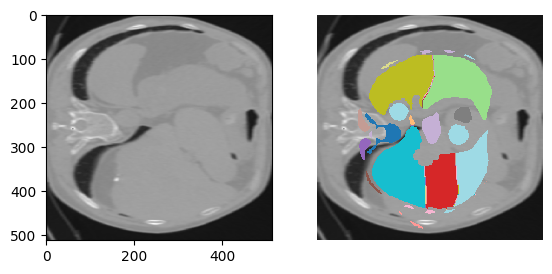

In [9]:
plot_slice_seg(X_train[0], y_train.iloc[2].values.reshape((512,512)))

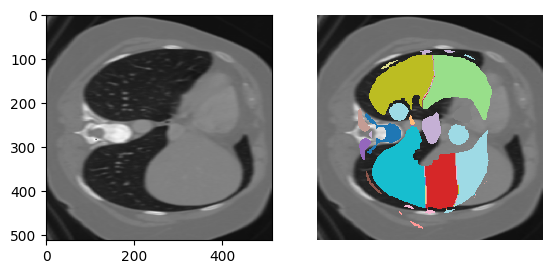

In [7]:
plot_slice_seg(X_train[2], y_train.iloc[2].values.reshape((512,512)))

### Felzenszwalb Model

In [5]:
def felzenszwalb_one_sample(data_slice, scale=1, sigma=0.8, min_size=20):
    label_predicted = felzenszwalb(data_slice, scale=scale, sigma=sigma, min_size=min_size)
    return label_predicted

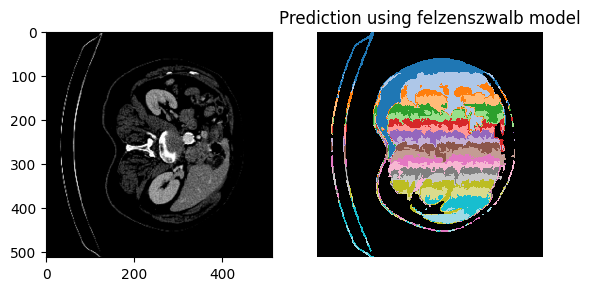

In [6]:
plot_slice_seg(X_train[0], felzenszwalb_one_sample(X_train[0]))
plt.title('Prediction using felzenszwalb model');

### Felzenszwalb Performances 

In [7]:
def compute_felzenszwalb(dataset: np.array, scale=1, sigma=0.8, min_size=20, verbosity=True):
    labels_predicted_list = []
    s = 0
    for index in range(np.shape(dataset)[0]):
        data_slice = dataset[index]
        label_predicted = felzenszwalb_one_sample(data_slice, scale=scale, sigma=sigma, min_size=min_size)
        labels_predicted_list.append(label_predicted)
        if verbosity:
            if s%20 == 0:
                print(f"Image {s}/200 processed")
        s =  s+1
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [8]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = X_train[:200]
labels_val = y_train.iloc[:200]

In [9]:
labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val)

Image 0/200 processed
Image 20/200 processed
Image 40/200 processed
Image 60/200 processed
Image 80/200 processed
Image 100/200 processed
Image 120/200 processed
Image 140/200 processed
Image 160/200 processed
Image 180/200 processed


In [12]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_felzenszwalb.sample(200))

0.11695756333514908

### Let's try to get the optimal params for the model with a grid search

In [92]:
def grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size):
    nb_possibilities = len(scale_range)*len(sigma_range)*len(min_size_range)
    print(f"Grid search will test {nb_possibilities} combinations")
    s = 0
    scores_dict = {}
    data = X_train[:data_size]
    labels = y_train.iloc[:data_size]
    for scale in scale_range:
        for sigma in sigma_range:
            for min_size in min_size_range:
                prediction = compute_felzenszwalb(data, scale, sigma, min_size, verbosity=False)
                score = rand_index_dataset(labels, prediction.sample(data_size))
                scores_dict[score] = {'scale_param':scale, 'sigma_param':sigma, 'min_size_param':min_size}
                s = s+1
                if s%100 == 0:
                    print(f"Combination {s}/{nb_possibilities}")
    best_params = scores_dict[max(scores_dict.keys())]
    return best_params

We run the grid search on a dataset of only 10 images, to avoid insane calculations

In [93]:
scale_range = np.arange(1, 100, 10)
sigma_range = np.arange(0.1, 1, 0.1)
min_size_range = np.arange(100, 2000, 100)
data_size = 10
grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size)

Grid search will test 1710 combinations
Combination 100/1710
Combination 200/1710
Combination 300/1710
Combination 400/1710
Combination 500/1710
Combination 600/1710
Combination 700/1710
Combination 800/1710
Combination 900/1710
Combination 1000/1710
Combination 1100/1710
Combination 1200/1710
Combination 1300/1710
Combination 1400/1710
Combination 1500/1710
Combination 1600/1710
Combination 1700/1710


{'scale_param': 51, 'sigma_param': 0.9, 'min_size_param': 900}

Let's test with theses params

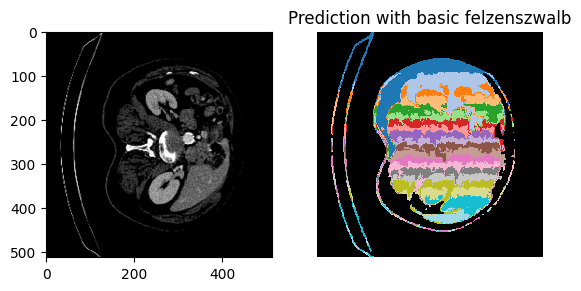

In [13]:
plot_slice_seg(X_train[0], felzenszwalb(X_train[0]))
plt.title('Prediction with basic felzenszwalb');

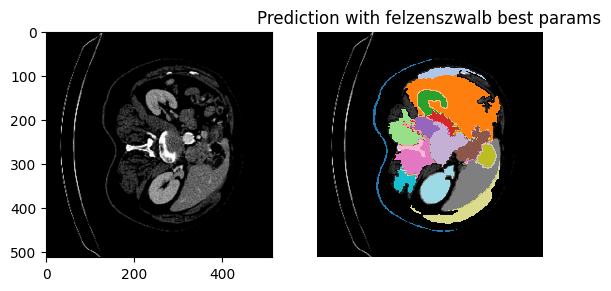

In [15]:
plot_slice_seg(X_train[0], felzenszwalb_one_sample(X_train[0], scale=51, sigma=0.9, min_size=900))
plt.title('Prediction with felzenszwalb best params');

Let's compute the felzenszwalb prediction on all our dataset

In [16]:
gs_labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val, scale=51, sigma=0.9, min_size=900)
rand_index_dataset(labels_val, gs_labels_val_predicted_felzenszwalb.sample(200))

Image 0/200 processed
Image 20/200 processed
Image 40/200 processed
Image 60/200 processed
Image 80/200 processed
Image 100/200 processed
Image 120/200 processed
Image 140/200 processed
Image 160/200 processed
Image 180/200 processed


0.20665408850495318

0.22 is much better than our baseline (0.14 with watershed)

### Combining felzenszwalb and k means

Next improvement : we remember that the kmeans poorly performs, but it does a very good background separation. We'll try to use Felzenszwalb algorithm and add the k means background separation

In [17]:
def k_means(data, k):
    s = 0
    predictions = []
    
    for image in data:
        flatten_image = image.reshape(image.shape[0] * image.shape[1], 1)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(flatten_image)
        clustered = kmeans.cluster_centers_[kmeans.labels_]
        predictions.append(clustered)
        s = s+1
        if s%20 == 0:
            print(f'Image {s}/200')
            
    return np.round(predictions)

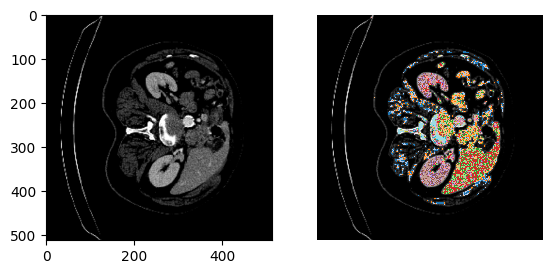

In [18]:
labels_vals_predicted_km = k_means(X_train[0:2], 6)
plot_slice_seg(X_train[0], labels_vals_predicted_km[0])

We will use k_mean on every picture, and replace the background of felzenszwalb with the k_means background

In [19]:
km_prediction = k_means(data_val, 6)

Image 20/200
Image 40/200
Image 60/200
Image 80/200
Image 100/200
Image 120/200
Image 140/200
Image 160/200
Image 180/200
Image 200/200


In [53]:
predicted_felzenszwalb = np.array(gs_labels_val_predicted_felzenszwalb).reshape(200, 512, 512).astype(int)

In [54]:
predicted_km = np.array(km_prediction).reshape(200, 512, 512).astype(int)

If a pixel is black on the km prediction, then it belongs to the background, so we replace the pixel on the felzenszwalb prediction by a black one

In [57]:
def replace_background(predicted_km, predicted_felzenszwalb):
    k_mean_felzenszwalb = []
    s = 0
    for index in range(len(predicted_felzenszwalb)):
        image = predicted_felzenszwalb[index].copy()
        km_image = predicted_km[index].copy()
        for x in range(512):
            for y in range(512):
                if km_image[x, y] == 0:
                    image[x, y] = 0
        k_mean_felzenszwalb.append(image)
        s = s+1
        if s%20 == 0:
            print(f"Image {s}/{len(predicted_felzenszwalb)} processed")
        
    return k_mean_felzenszwalb

In [58]:
k_mean_felzenswalb = replace_background(predicted_km, predicted_felzenszwalb)

Image 20/200 processed
Image 40/200 processed
Image 60/200 processed
Image 80/200 processed
Image 100/200 processed
Image 120/200 processed
Image 140/200 processed
Image 160/200 processed
Image 180/200 processed
Image 200/200 processed


In [88]:
i = 0

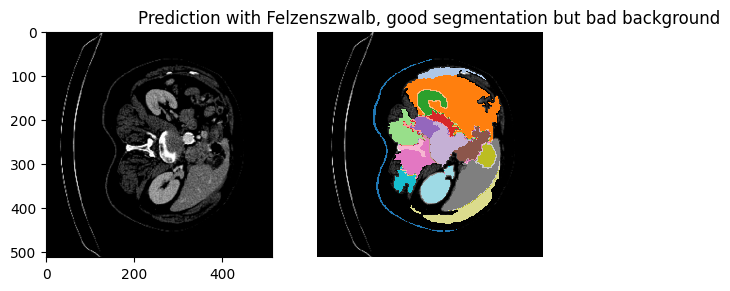

In [89]:
plot_slice_seg(data_val[i], predicted_felzenszwalb[i])
plt.title('Prediction with Felzenszwalb, good segmentation but bad background');

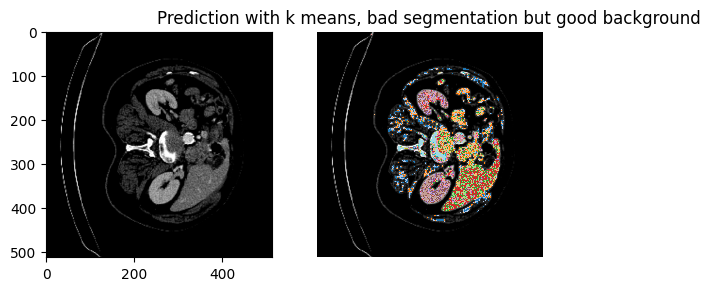

In [90]:
plot_slice_seg(data_val[i], predicted_km[i])
plt.title('Prediction with k means, bad segmentation but good background');

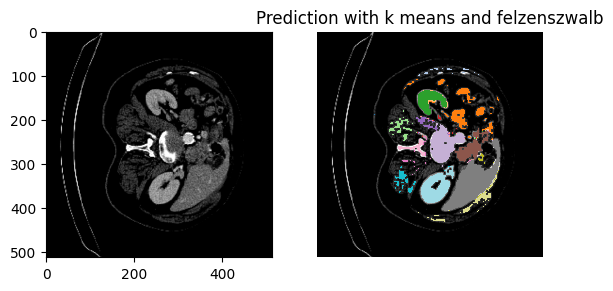

In [91]:
plot_slice_seg(data_val[i], k_mean_felzenswalb[i])
plt.title('Prediction with k means and felzenszwalb');

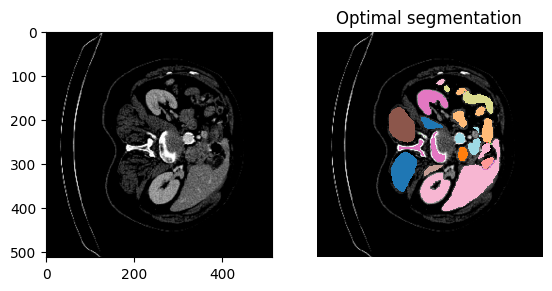

In [92]:
plot_slice_seg(data_val[i], df_get_ith_image(labels_val, i))
plt.title('Optimal segmentation');

We notice that replacing the background provides much better image segmentation. Let's compute the score

In [66]:
rand_index_dataset(labels_val, prediction_to_df(k_mean_felzenswalb).sample(200))

0.11638851404175388

The score is worse, even though the segmentation is better. Maybe with a better k in the k means, we could have a better score. We'll try to do a grid search to determine it.

### Grid search for optimal k in k_means background replace on felzenszwalb prediction